In [1]:
# import useful libraries for data preprocessing
import numpy as np
import pandas as pd
from numpy import linalg as LA
import seaborn as sns

In [2]:
# change the current path for referencing
import sys
sys.path.append('../')

In [3]:
import os
os.path.abspath(os.getcwd())

'/Users/guoyihan/Downloads'

In [4]:
# read the new 10000_9.csv file
df_10000_9_new = pd.read_csv(r"./data/10000_9.csv")
df_10000_9_new

,Unnamed: 0,braid,free_part,torsion_part,total_num_FP,total_num_TP
0,0,"[-2, 2, -3, 3, -2, -2, 1, -3, -3]","{(-11, -4): 1, (-9, -4): 1, (-7, -2): 2, (-5, ...",{},8,0
1,1,"[3, -1, -2, 2, -2, -2, -3, 3, -1]","{(-11, -4): 1, (-9, -4): 1, (-7, -2): 2, (-5, ...",{},8,0
2,2,"[1, -3, 2, 3, 2, 2, 1, 2, -1]","{(1, 0): 1, (3, 0): 1, (5, 2): 1, (9, 3): 1}","{(7, 3): {2: 1}}",4,1
3,3,"[-1, -1, 1, -1, 3, -2, -1, 3, -2]","{(-11, -4): 1, (-9, -3): 1, (-7, -3): 1, (-7, ...","{(-9, -3): {2: 1}, (-7, -2): {2: 1}, (-5, -1):...",12,5
4,4,"[1, -3, -2, 3, 1, 1, 2, -1, -3]","{(-5, -2): 1, (-3, -2): 1, (-1, 0): 2, (1, 0):...",{},8,0
...,...,...,...,...,...,...
9995,9995,"[2, 1, -1, 2, -3, 1, -3, 1, -3]","{(-7, -3): 1, (-3, -2): 1, (-3, -1): 2, (-1, 0...","{(-5, -2): {2: 1}, (-1, 0): {2: 2}, (3, 2): {2...",16,4
9996,9996,"[-1, 2, -1, 1, -1, 1, -1, -2, -1]","{(-6, -2): 1, (-4, -2): 1, (-2, 0): 1, (0, 0): 1}",{},4,0
9997,9997,"[1, -3, -1, -3, -2, -3, 2, 2, 3]","{(-3, 0): 1, (-1, 0): 3, (1, 0): 3, (3, 0): 1}",{},8,0
9998,9998,"[-2, 2, 3, -2, 3, 2, -1, -2, -3]","{(-1, 0): 1, (1, 0): 1}",{},2,0


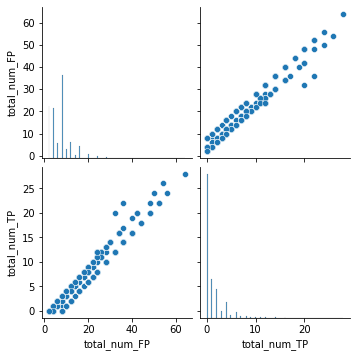

In [5]:
# look at data distribution using seaborn plot
sns.pairplot(df_10000_9_new.drop(columns=['Unnamed: 0', 'braid', 'free_part', 'torsion_part']))

In [6]:
# Use the functions we built to find parameters and make testing predictions
def generate_monomials_eq(n,k):
    ######################### your code goes here ########################
    if n == 1: 
        yield [k,]
    else:
        for i in range(k+1):
            for j in generate_monomials_eq(n-1,k-i):
                yield [i,] + j
def generate_monomials_leq(n,k): 
    ######################### your code goes here ########################
    L = []
    for i in range(k+1):
        Lh = list(generate_monomials_eq(n,i))
        Lh.sort(reverse = True)
        L += Lh
    return L
def add_poly_terms(X,k):
    ######################### your code goes here ########################
    n = len(X[0])
    mons = generate_monomials_leq(n,k)
    L = []
    for mon in mons:
        X1 = np.ones(len(X))
        for i in range(n):
            X1 *= X[:,i]**mon[i]
        L.append(X1)
    return(np.array(L).T)


In [7]:
def J(X,y,v,lambda_):
    ######################### your code goes here ########################
    rowx = len(X)
    J = LA.norm(X@v-y)**2
    re = LA.norm(v,2)**2
    return (1/rowx)*J + lambda_*re

def DJ(X,y,v,lambda_):
    ######################### your code goes here ########################
    rowx = len(X)
    gradient = X.T@X@v-X.T@y
    reg = 2*v
    return (2/rowx)*gradient + lambda_*reg

def GD_linreg_improved(X,y,epsilon,lambda_,max_iters = 10000): 
    ######################### your code goes here ########################
    a = X.shape
    v = np.zeros([a[1],1])
    H = (2/a[0])*X.T@X+2*lambda_*np.identity(a[1])
    costs = [J(X,y,v,lambda_)]
    for i in range(max_iters):
        alpha = (DJ(X,y,v,lambda_).T@DJ(X,y,v,lambda_))/(DJ(X,y,v,lambda_).T@H@DJ(X,y,v,lambda_))
        v = v-DJ(X,y,v,lambda_)*alpha
        costs.append(J(X,y,v,lambda_))
        if i % 1000 == 0:
            print(f'after {i} steps the cost is {costs[i]}')
        if abs(costs[i] - costs[i-1])<epsilon:
            break
    print(f'after {i} steps the cost is {costs[i]}')
    return v,costs

In [8]:
def predict(X,v,y):
    r = np.vectorize(round) 
    X_r = r(X@v)    
    output = [a == p for a,p in zip(y,X_r)]
    count = len([val for val in output if val == False])
    J = LA.norm(X@v-y)**2
    rowx = len(X_test)
    cost = (1/rowx)*J
    return count,cost

In [9]:
X = (np.array(df_10000_9_new.total_num_FP)).reshape(-1, 1)
y = (np.array(df_10000_9_new.total_num_TP)).reshape(-1,1)
X2 = add_poly_terms(X,1)
X_train = X2[0:8000]
y_train = y[0:8000]

In [10]:
lambda_ = 0.1
epsilon = 0.01
v1,costs =  GD_linreg_improved(X_train,y_train,epsilon,lambda_) 
print(v1)

after 0 steps the cost is 6.809625
after 4 steps the cost is 1.660043518047414
[[-1.08284034]
 [ 0.3345881 ]]


In [11]:
X_val = X2[8001:9001]
y_val = y[8001:9001]

In [12]:
lambda_ = 0.1
epsilon = 0.01
v2,costs =  GD_linreg_improved(X_val,y_val,epsilon,lambda_)
print(v2)

after 0 steps the cost is 5.6080000000000005
after 4 steps the cost is 1.6465988811579058
[[-1.00705802]
 [ 0.31439978]]


In [13]:
X_test = X2[9002:10000]
y_test = y[9002:10000]

In [15]:
predict(X_test,v2,y_test)

(673, 1.5075493896516643)

In [ ]:
# try to make prediction using LinearRegression and libraries from sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report

# need to reshape X because there is only one feature in X (i.e. X is currently a row vector, need to convert it to a column vector)
X = (np.array(df_10000_9_new.total_num_FP)).reshape(-1, 1)
y = (np.array(df_10000_9_new.total_num_TP))

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit the data in LinearRegression (i.e. train the LinearRegression model using the training data X and Y)
linreg = LinearRegression().fit(X_train,y_train)

# see the accuracy of training and testing (i.e. measure performance of the LinearRegressing model)
linreg.score(X_train,y_train), linreg.score(X_test,y_test)